# Chapter7 RNN을 사용한 문장 생성

## 7.1 언어 모델을 사용한 문장 생성

### 7.1.1 RNN을 사용한 문장 생성의 순서
- 확률이 가장 높은 단어를 선택 반복

### 7.1.2 문장 생성 구현
- start_id : 최초로 주는 단어의 ID
- sample_size : 샘플링하는 단어의 수
- skip_id : 단어 ID의 리스트
- generate() : model.predict(x)를 호출해 각 단어의 점수 출력

In [9]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from common.rnnlm import Rnnlm
from common.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

In [10]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you championship compare ashland automobiles dispatched a.m. fastest-growing sterling comair contact memorandum indicator selected wilson raise projections drivers drivers gainers multiple delivered shown underscore prepares prescription swing volunteer roughly manpower shah disrupted buy causes ltd milwaukee kkr liabilities connection jamaica accuse flights e. successfully baltimore mills printed balanced data passage casting desirable illuminating speeding medical background vermont-slauson alleges symbol morally strict missouri airlines soo cumulative at&t brilliant matched audience w. privileges sworn contributing treasury suburb policies maneuver sink study processed hint negligible current bergsma trucks devastation gelbart radio financially jetliner scene s. extraordinarily preferred palmer keeping va. hundred extraordinarily reviews


In [11]:
' '.join(['you', 'say', 'goodbye'])

'you say goodbye'

### 7.1.3 더 좋은 문장으로

In [15]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from common.better_rnnlm import BetterRnnlm


class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)

In [17]:
import sys
sys.path.append('..')
from common.np import *
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you knowledgeable steinhardt painted artistic occurred reservations ifi concessions arkla mutual-fund margins brunt rear schroder dealerships social considerably traub sell wedge scale bros. were intensity liked baum mitterrand cubic titles house-passed aliens vicar treated shaking gerrymandering letters understands school borrowers martin manager lang unconsolidated taxpayers severance fish coda usage urging interest-rate quantum high-definition literary mit monitor asbestos annuity peddling aide sector digest pickup ernst talks endless knew bound effectively newcomers dogs gear phased ramirez ernst consequence pressures combined unsuccessfully floating colgate-palmolive sidewalk experienced preserve disputes crystal findings west disagree cbs alert magnetic finnair inner-city implement shrinking rapidly aside mainframe positioned
--------------------------------------------------
the meaning of life is calif. irving merc motorola financial christmas registered apparently abuse chance

## 7.2 seq2seq

### 7.2.1 seq2seq의 원리
- seq2seq : Encoder - Decoder 모델
- Encoder가 인코딩한 정보에는 번역에 필요한 정보가 조밀하게 응축
- Decoder는 조밀하게 응축된 정보를 바탕으로 도착어 문장 생성

### 7.2.2 시계열 데이터 변환용 장난감 문제
- 장난감 문제 toy problem: 머신러닝을 평가하고자 만든 간단한 문제

### 7.2.3 가변 길이 시계열 데이터
- 가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 패딩을 사용하는 것
- 모든 입력 데이터의 길이를 통일하고 남는 공간에는 의미없는 데이터 채우기
- seq2seq에 패딩 전용 처리 추가

### 7.2.4 덧셈 데이터셋

In [19]:
import sys
sys.path.append('..')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## 7.3 seq2seq 구현

### 7.3.1 Encoder 클래스

In [20]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 7.3.2 Decoder 클래스

In [21]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

### 7.3.3 seq2seq 클래스
- Encoder Decoder 연결

In [22]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### 7.3.4 seq2seq 평가
1. 학습 데이터에서 미니배치 선택
2. 미니배치로부터 기울기 계산
3. 기울기를 사용하여 매개변수 갱신

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 5[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 7[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 9[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 10[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 12[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 13[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 14[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 16[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 17[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 18[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 20[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 21[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 23[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 58

| epoch 7 |  iter 101 / 351 | time 9[s] | loss 1.08
| epoch 7 |  iter 121 / 351 | time 10[s] | loss 1.08
| epoch 7 |  iter 141 / 351 | time 12[s] | loss 1.08
| epoch 7 |  iter 161 / 351 | time 14[s] | loss 1.08
| epoch 7 |  iter 181 / 351 | time 16[s] | loss 1.09
| epoch 7 |  iter 201 / 351 | time 17[s] | loss 1.07
| epoch 7 |  iter 221 / 351 | time 19[s] | loss 1.08
| epoch 7 |  iter 241 / 351 | time 21[s] | loss 1.06
| epoch 7 |  iter 261 / 351 | time 23[s] | loss 1.06
| epoch 7 |  iter 281 / 351 | time 24[s] | loss 1.06
| epoch 7 |  iter 301 / 351 | time 26[s] | loss 1.06
| epoch 7 |  iter 321 / 351 | time 28[s] | loss 1.06
| epoch 7 |  iter 341 / 351 | time 30[s] | loss 1.04
Q 77+85  
T 162 
☒ 166 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 655 
---
Q 8+155  
T 163 
☒ 161 
---
Q 367+55 
T 422 
☒ 409 
---
Q 600+257
T 857 
☒ 892 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1444
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 228 
---
검증 정확도 4.160%
| epoch 8 |  iter 

| epoch 13 |  iter 181 / 351 | time 15[s] | loss 0.90
| epoch 13 |  iter 201 / 351 | time 17[s] | loss 0.93
| epoch 13 |  iter 221 / 351 | time 19[s] | loss 0.94
| epoch 13 |  iter 241 / 351 | time 20[s] | loss 0.92
| epoch 13 |  iter 261 / 351 | time 22[s] | loss 0.92
| epoch 13 |  iter 281 / 351 | time 24[s] | loss 0.92
| epoch 13 |  iter 301 / 351 | time 26[s] | loss 0.91
| epoch 13 |  iter 321 / 351 | time 27[s] | loss 0.91
| epoch 13 |  iter 341 / 351 | time 29[s] | loss 0.91
Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1110
---
Q 582+84 
T 666 
☒ 659 
---
Q 8+155  
T 163 
☒ 164 
---
Q 367+55 
T 422 
☒ 411 
---
Q 600+257
T 857 
☒ 841 
---
Q 761+292
T 1053
☒ 1031
---
Q 830+597
T 1427
☒ 1394
---
Q 26+838 
T 864 
☒ 859 
---
Q 143+93 
T 236 
☒ 239 
---
검증 정확도 4.300%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.96
| epoch 14 |  iter 21 / 351 | time 1[s] | loss 0.92
| epoch 14 |  iter 41 / 351 | time 3[s] | loss 0.91
| epoch 14 |  iter 61 / 351 | time 5[s] | loss 0.90
| epoch 14 | 

| epoch 19 |  iter 241 / 351 | time 21[s] | loss 0.82
| epoch 19 |  iter 261 / 351 | time 23[s] | loss 0.86
| epoch 19 |  iter 281 / 351 | time 25[s] | loss 0.84
| epoch 19 |  iter 301 / 351 | time 26[s] | loss 0.84
| epoch 19 |  iter 321 / 351 | time 28[s] | loss 0.83
| epoch 19 |  iter 341 / 351 | time 30[s] | loss 0.83
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 672 
---
Q 8+155  
T 163 
☒ 167 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1049
---
Q 830+597
T 1427
☒ 1424
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 239 
---
검증 정확도 10.500%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.79
| epoch 20 |  iter 21 / 351 | time 1[s] | loss 0.83
| epoch 20 |  iter 41 / 351 | time 3[s] | loss 0.82
| epoch 20 |  iter 61 / 351 | time 5[s] | loss 0.85
| epoch 20 |  iter 81 / 351 | time 7[s] | loss 0.83
| epoch 20 |  iter 101 / 351 | time 8[s] | loss 0.80
| epoch 20 |  iter 121 / 351 | time 10[s] | loss 0.82
| epoch 20 |  i

| epoch 25 |  iter 301 / 351 | time 26[s] | loss 0.80
| epoch 25 |  iter 321 / 351 | time 28[s] | loss 0.85
| epoch 25 |  iter 341 / 351 | time 30[s] | loss 0.75
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1146
---
Q 582+84 
T 666 
☒ 659 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 859 
---
Q 761+292
T 1053
☒ 1061
---
Q 830+597
T 1427
☒ 1418
---
Q 26+838 
T 864 
☒ 862 
---
Q 143+93 
T 236 
☑ 236 
---
검증 정확도 10.640%


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

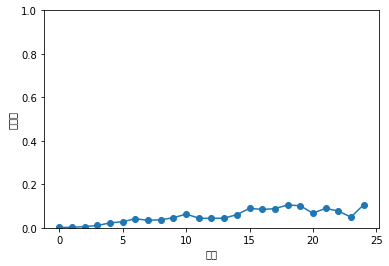

In [25]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from common.seq2seq import Seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()


# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hideen_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

## 7.4 seq2seq 개선

### 7.4.1 입력 데이터 반전 (Reverse)
- 입력 데이터의 순서 반전
- 학습 진행이 빨라져서 최종 정확도도 좋아짐

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 5[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 8[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 9[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 10[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 12[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 13[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 15[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 16[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 17[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 19[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 20[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 22[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 23[s] | loss 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1000
---
Q  4

| epoch 7 |  iter 101 / 351 | time 9[s] | loss 0.68
| epoch 7 |  iter 121 / 351 | time 10[s] | loss 0.67
| epoch 7 |  iter 141 / 351 | time 12[s] | loss 0.67
| epoch 7 |  iter 161 / 351 | time 14[s] | loss 0.67
| epoch 7 |  iter 181 / 351 | time 16[s] | loss 0.66
| epoch 7 |  iter 201 / 351 | time 17[s] | loss 0.66
| epoch 7 |  iter 221 / 351 | time 19[s] | loss 0.66
| epoch 7 |  iter 241 / 351 | time 21[s] | loss 0.64
| epoch 7 |  iter 261 / 351 | time 23[s] | loss 0.65
| epoch 7 |  iter 281 / 351 | time 25[s] | loss 0.64
| epoch 7 |  iter 301 / 351 | time 26[s] | loss 0.63
| epoch 7 |  iter 321 / 351 | time 28[s] | loss 0.63
| epoch 7 |  iter 341 / 351 | time 30[s] | loss 0.62
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☒ 1142
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☒ 162 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☒ 859 
---
Q 292+167
T 1053
☒ 1144
---
Q 795+038
T 1427
☒ 1431
---
Q  838+62
T 864 
☒ 866 
---
Q  39+341
T 236 
☒ 239 
---
검증 정확도 17.500%
| epoch 8 |  iter

| epoch 13 |  iter 181 / 351 | time 16[s] | loss 0.42
| epoch 13 |  iter 201 / 351 | time 17[s] | loss 0.42
| epoch 13 |  iter 221 / 351 | time 19[s] | loss 0.43
| epoch 13 |  iter 241 / 351 | time 21[s] | loss 0.43
| epoch 13 |  iter 261 / 351 | time 23[s] | loss 0.41
| epoch 13 |  iter 281 / 351 | time 25[s] | loss 0.42
| epoch 13 |  iter 301 / 351 | time 26[s] | loss 0.41
| epoch 13 |  iter 321 / 351 | time 28[s] | loss 0.43
| epoch 13 |  iter 341 / 351 | time 30[s] | loss 0.40
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☒ 1140
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☒ 162 
---
Q  55+763
T 422 
☒ 424 
---
Q 752+006
T 857 
☒ 856 
---
Q 292+167
T 1053
☒ 1054
---
Q 795+038
T 1427
☒ 1429
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☒ 239 
---
검증 정확도 39.420%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.41
| epoch 14 |  iter 21 / 351 | time 2[s] | loss 0.41
| epoch 14 |  iter 41 / 351 | time 3[s] | loss 0.41
| epoch 14 |  iter 61 / 351 | time 5[s] | loss 0.40
| epoch 14 |

| epoch 19 |  iter 241 / 351 | time 21[s] | loss 0.32
| epoch 19 |  iter 261 / 351 | time 23[s] | loss 0.33
| epoch 19 |  iter 281 / 351 | time 24[s] | loss 0.33
| epoch 19 |  iter 301 / 351 | time 26[s] | loss 0.32
| epoch 19 |  iter 321 / 351 | time 28[s] | loss 0.33
| epoch 19 |  iter 341 / 351 | time 30[s] | loss 0.33
Q   58+77
T 162 
☒ 161 
---
Q 461+579
T 1139
☒ 1140
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☒ 858 
---
Q 292+167
T 1053
☒ 1052
---
Q 795+038
T 1427
☒ 1430
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☒ 238 
---
검증 정확도 47.560%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.32
| epoch 20 |  iter 21 / 351 | time 1[s] | loss 0.35
| epoch 20 |  iter 41 / 351 | time 3[s] | loss 0.33
| epoch 20 |  iter 61 / 351 | time 5[s] | loss 0.33
| epoch 20 |  iter 81 / 351 | time 7[s] | loss 0.31
| epoch 20 |  iter 101 / 351 | time 9[s] | loss 0.31
| epoch 20 |  iter 121 / 351 | time 10[s] | loss 0.33
| epoch 20 |  i

| epoch 25 |  iter 301 / 351 | time 26[s] | loss 0.27
| epoch 25 |  iter 321 / 351 | time 28[s] | loss 0.28
| epoch 25 |  iter 341 / 351 | time 30[s] | loss 0.28
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☒ 1140
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☒ 856 
---
Q 292+167
T 1053
☒ 1052
---
Q 795+038
T 1427
☒ 1426
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
검증 정확도 54.200%


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

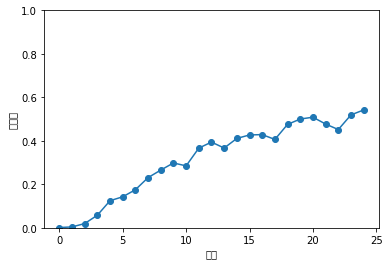

In [26]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from common.seq2seq import Seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

char_to_id, id_to_char = sequence.get_vocab()


# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hideen_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### 7.4.2 엿보기 (Peeky)
- 중요한 정보가 담긴 Encoder의 출력 h를 Decoder의 다른 계층에게 전달
- Peeky를 이용하게 되면 신경망의 가중치 매개변수가 커져서 계산량이 늘어남
- 또한 seq2seq의 정확도는 하이퍼파라미터에 영향을 크게 받음

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.48
| epoch 1 |  iter 41 / 351 | time 3[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 5[s] | loss 1.99
| epoch 1 |  iter 81 / 351 | time 7[s] | loss 1.89
| epoch 1 |  iter 101 / 351 | time 9[s] | loss 1.82
| epoch 1 |  iter 121 / 351 | time 11[s] | loss 1.82
| epoch 1 |  iter 141 / 351 | time 12[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 14[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 16[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 18[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 20[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 22[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 23[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 26[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 28[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 30[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 33[s] | loss 1.73
Q   58+77
T 162 
☒ 100 
---
Q 461+579
T 1139
☒ 1013
---
Q 

| epoch 7 |  iter 101 / 351 | time 12[s] | loss 0.65
| epoch 7 |  iter 121 / 351 | time 14[s] | loss 0.65
| epoch 7 |  iter 141 / 351 | time 17[s] | loss 0.64
| epoch 7 |  iter 161 / 351 | time 19[s] | loss 0.63
| epoch 7 |  iter 181 / 351 | time 22[s] | loss 0.61
| epoch 7 |  iter 201 / 351 | time 24[s] | loss 0.61
| epoch 7 |  iter 221 / 351 | time 27[s] | loss 0.60
| epoch 7 |  iter 241 / 351 | time 29[s] | loss 0.57
| epoch 7 |  iter 261 / 351 | time 31[s] | loss 0.57
| epoch 7 |  iter 281 / 351 | time 34[s] | loss 0.57
| epoch 7 |  iter 301 / 351 | time 36[s] | loss 0.55
| epoch 7 |  iter 321 / 351 | time 39[s] | loss 0.54
| epoch 7 |  iter 341 / 351 | time 41[s] | loss 0.53
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☑ 1139
---
Q  48+285
T 666 
☒ 665 
---
Q   551+8
T 163 
☒ 156 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☒ 858 
---
Q 292+167
T 1053
☒ 1052
---
Q 795+038
T 1427
☒ 1428
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☒ 235 
---
검증 정확도 39.100%
| epoch 8 |  ite

| epoch 13 |  iter 161 / 351 | time 20[s] | loss 0.06
| epoch 13 |  iter 181 / 351 | time 22[s] | loss 0.06
| epoch 13 |  iter 201 / 351 | time 25[s] | loss 0.06
| epoch 13 |  iter 221 / 351 | time 27[s] | loss 0.06
| epoch 13 |  iter 241 / 351 | time 30[s] | loss 0.06
| epoch 13 |  iter 261 / 351 | time 32[s] | loss 0.06
| epoch 13 |  iter 281 / 351 | time 35[s] | loss 0.06
| epoch 13 |  iter 301 / 351 | time 37[s] | loss 0.05
| epoch 13 |  iter 321 / 351 | time 40[s] | loss 0.05
| epoch 13 |  iter 341 / 351 | time 42[s] | loss 0.06
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☑ 1139
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☑ 857 
---
Q 292+167
T 1053
☑ 1053
---
Q 795+038
T 1427
☑ 1427
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
검증 정확도 94.380%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.05
| epoch 14 |  iter 21 / 351 | time 2[s] | loss 0.05
| epoch 14 |  iter 41 / 351 | time 5[s] | loss 0.05
| epoch 14

| epoch 19 |  iter 221 / 351 | time 27[s] | loss 0.02
| epoch 19 |  iter 241 / 351 | time 30[s] | loss 0.02
| epoch 19 |  iter 261 / 351 | time 32[s] | loss 0.02
| epoch 19 |  iter 281 / 351 | time 35[s] | loss 0.02
| epoch 19 |  iter 301 / 351 | time 37[s] | loss 0.02
| epoch 19 |  iter 321 / 351 | time 40[s] | loss 0.02
| epoch 19 |  iter 341 / 351 | time 42[s] | loss 0.02
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☑ 1139
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☑ 857 
---
Q 292+167
T 1053
☑ 1053
---
Q 795+038
T 1427
☑ 1427
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
검증 정확도 98.640%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.01
| epoch 20 |  iter 21 / 351 | time 2[s] | loss 0.01
| epoch 20 |  iter 41 / 351 | time 5[s] | loss 0.01
| epoch 20 |  iter 61 / 351 | time 8[s] | loss 0.01
| epoch 20 |  iter 81 / 351 | time 11[s] | loss 0.01
| epoch 20 |  iter 101 / 351 | time 13[s] | loss 0.01
| epoch 20 | 

| epoch 25 |  iter 281 / 351 | time 34[s] | loss 0.01
| epoch 25 |  iter 301 / 351 | time 36[s] | loss 0.01
| epoch 25 |  iter 321 / 351 | time 39[s] | loss 0.01
| epoch 25 |  iter 341 / 351 | time 41[s] | loss 0.01
Q   58+77
T 162 
☑ 162 
---
Q 461+579
T 1139
☑ 1139
---
Q  48+285
T 666 
☑ 666 
---
Q   551+8
T 163 
☑ 163 
---
Q  55+763
T 422 
☑ 422 
---
Q 752+006
T 857 
☑ 857 
---
Q 292+167
T 1053
☑ 1053
---
Q 795+038
T 1427
☑ 1427
---
Q  838+62
T 864 
☑ 864 
---
Q  39+341
T 236 
☑ 236 
---
검증 정확도 98.840%


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

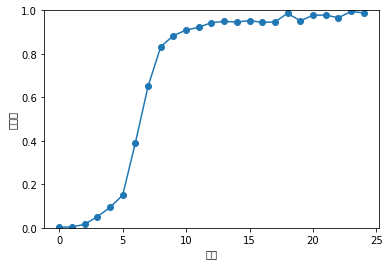

In [28]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from common.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

char_to_id, id_to_char = sequence.get_vocab()


# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

## 7.5 seq2seq를 이용하는 애플리케이션
- seq2seq: 한 시계열 데이터 -> 다른 시계열 데이터
- 기계번역: '한 언어의 문장'을 '다른 언어의 문장'으로 변환
- 자동 요약: '긴 문장'을 '짧게 요약된 문장'으로 변환
- 질의응답: '질문'을 '응답'으로 변환
- 메일 자동 응답: '받은 메일의 문장'을 '답변 글'로 변환

### 7.5.1 챗봇
- 사람과 컴퓨터가 텍스트로 대화를 나누는 프로그램

### 7.5.2 알고리즘 학습

### 7.5.3 이미지 캡셔닝
- 이미지 캡셔닝 Image Captioning : 이미지를 문장으로 변환
- Encoder가 LSTM엣 CNN으로 바뀜
- CNN의 특징 맵(feature map)을 1차원으로 평탄화한 후 완전연결인 Affine 계층에서 변환
- ex) im2txt